# Hands on : introduction to NN on HEP dataset

### Many thanks to _Rafael Coelho Lopes de Sa, Jay Chan, Gordon Watts, Chris Tunnell, Fernando Torales Acosta, David Rousseau, Yann Coadou_, and _Aishik Ghosh_

This tutorial will be focused on the classification problem in a physics example: training a neural network classifier to distinguish the Higgs boson signals from background events.

In this tutorial, we will use TensorFlow and Keras to train our neural networks (different from the first hands on tutorial which uses PyTorch), but the concept is the same, and we will be focused more on data processing, model optimization and overtraining.

Outline:
- Load data from root files
- Explore the data and weights
- Preprocess data for training
- Train a neural network
- Quantify its performance
- Tune the model and overtraining

<CENTER>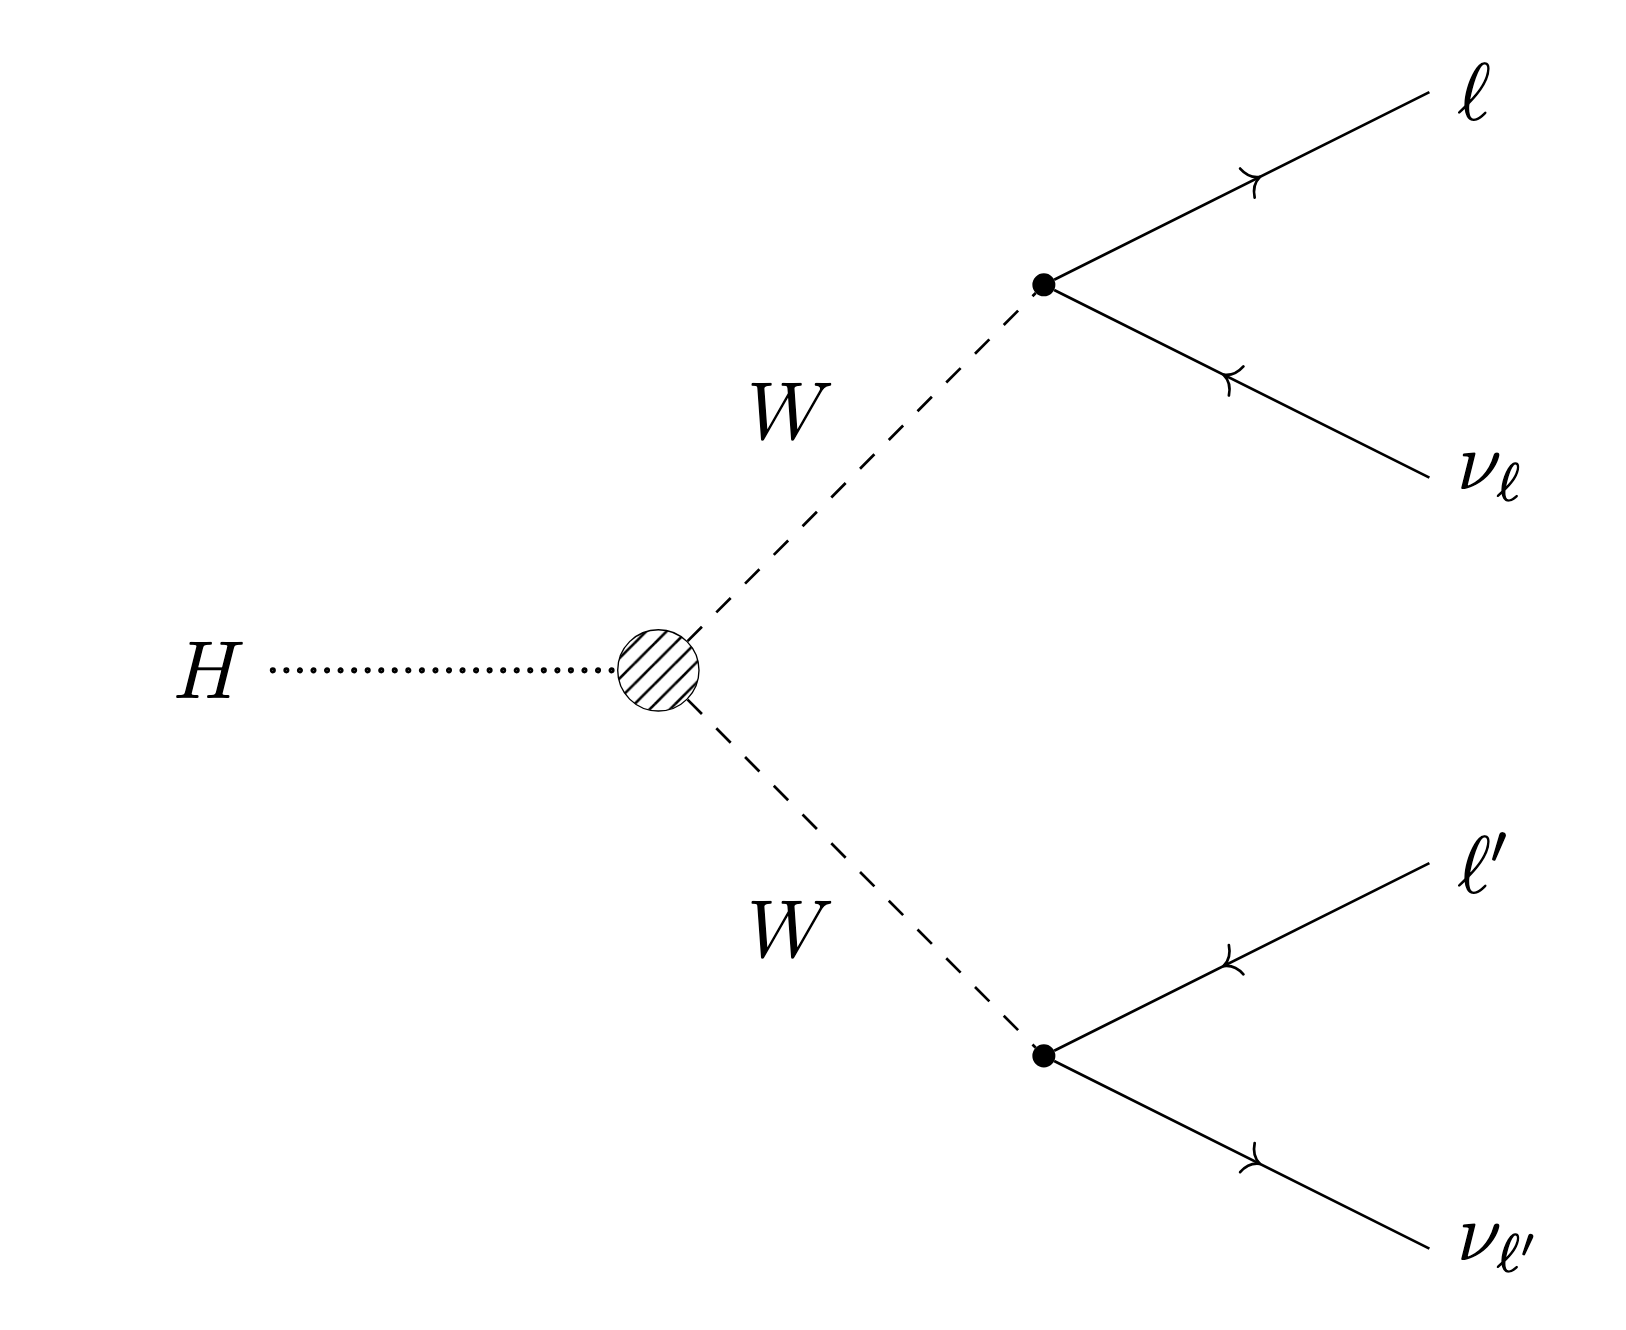</CENTER>

<CENTER>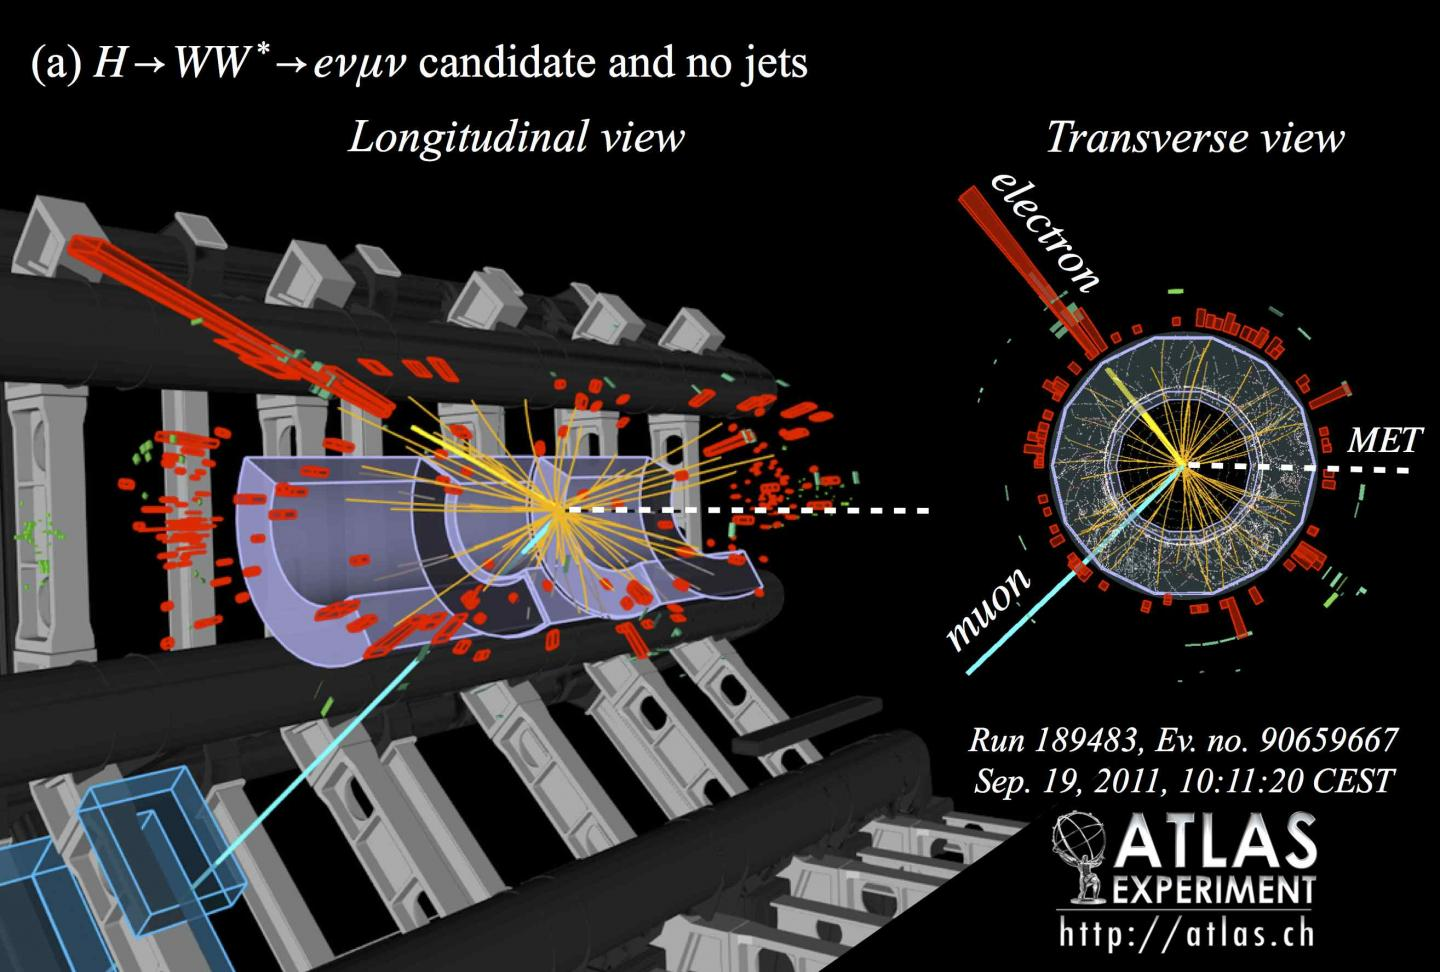</CENTER>

<CENTER>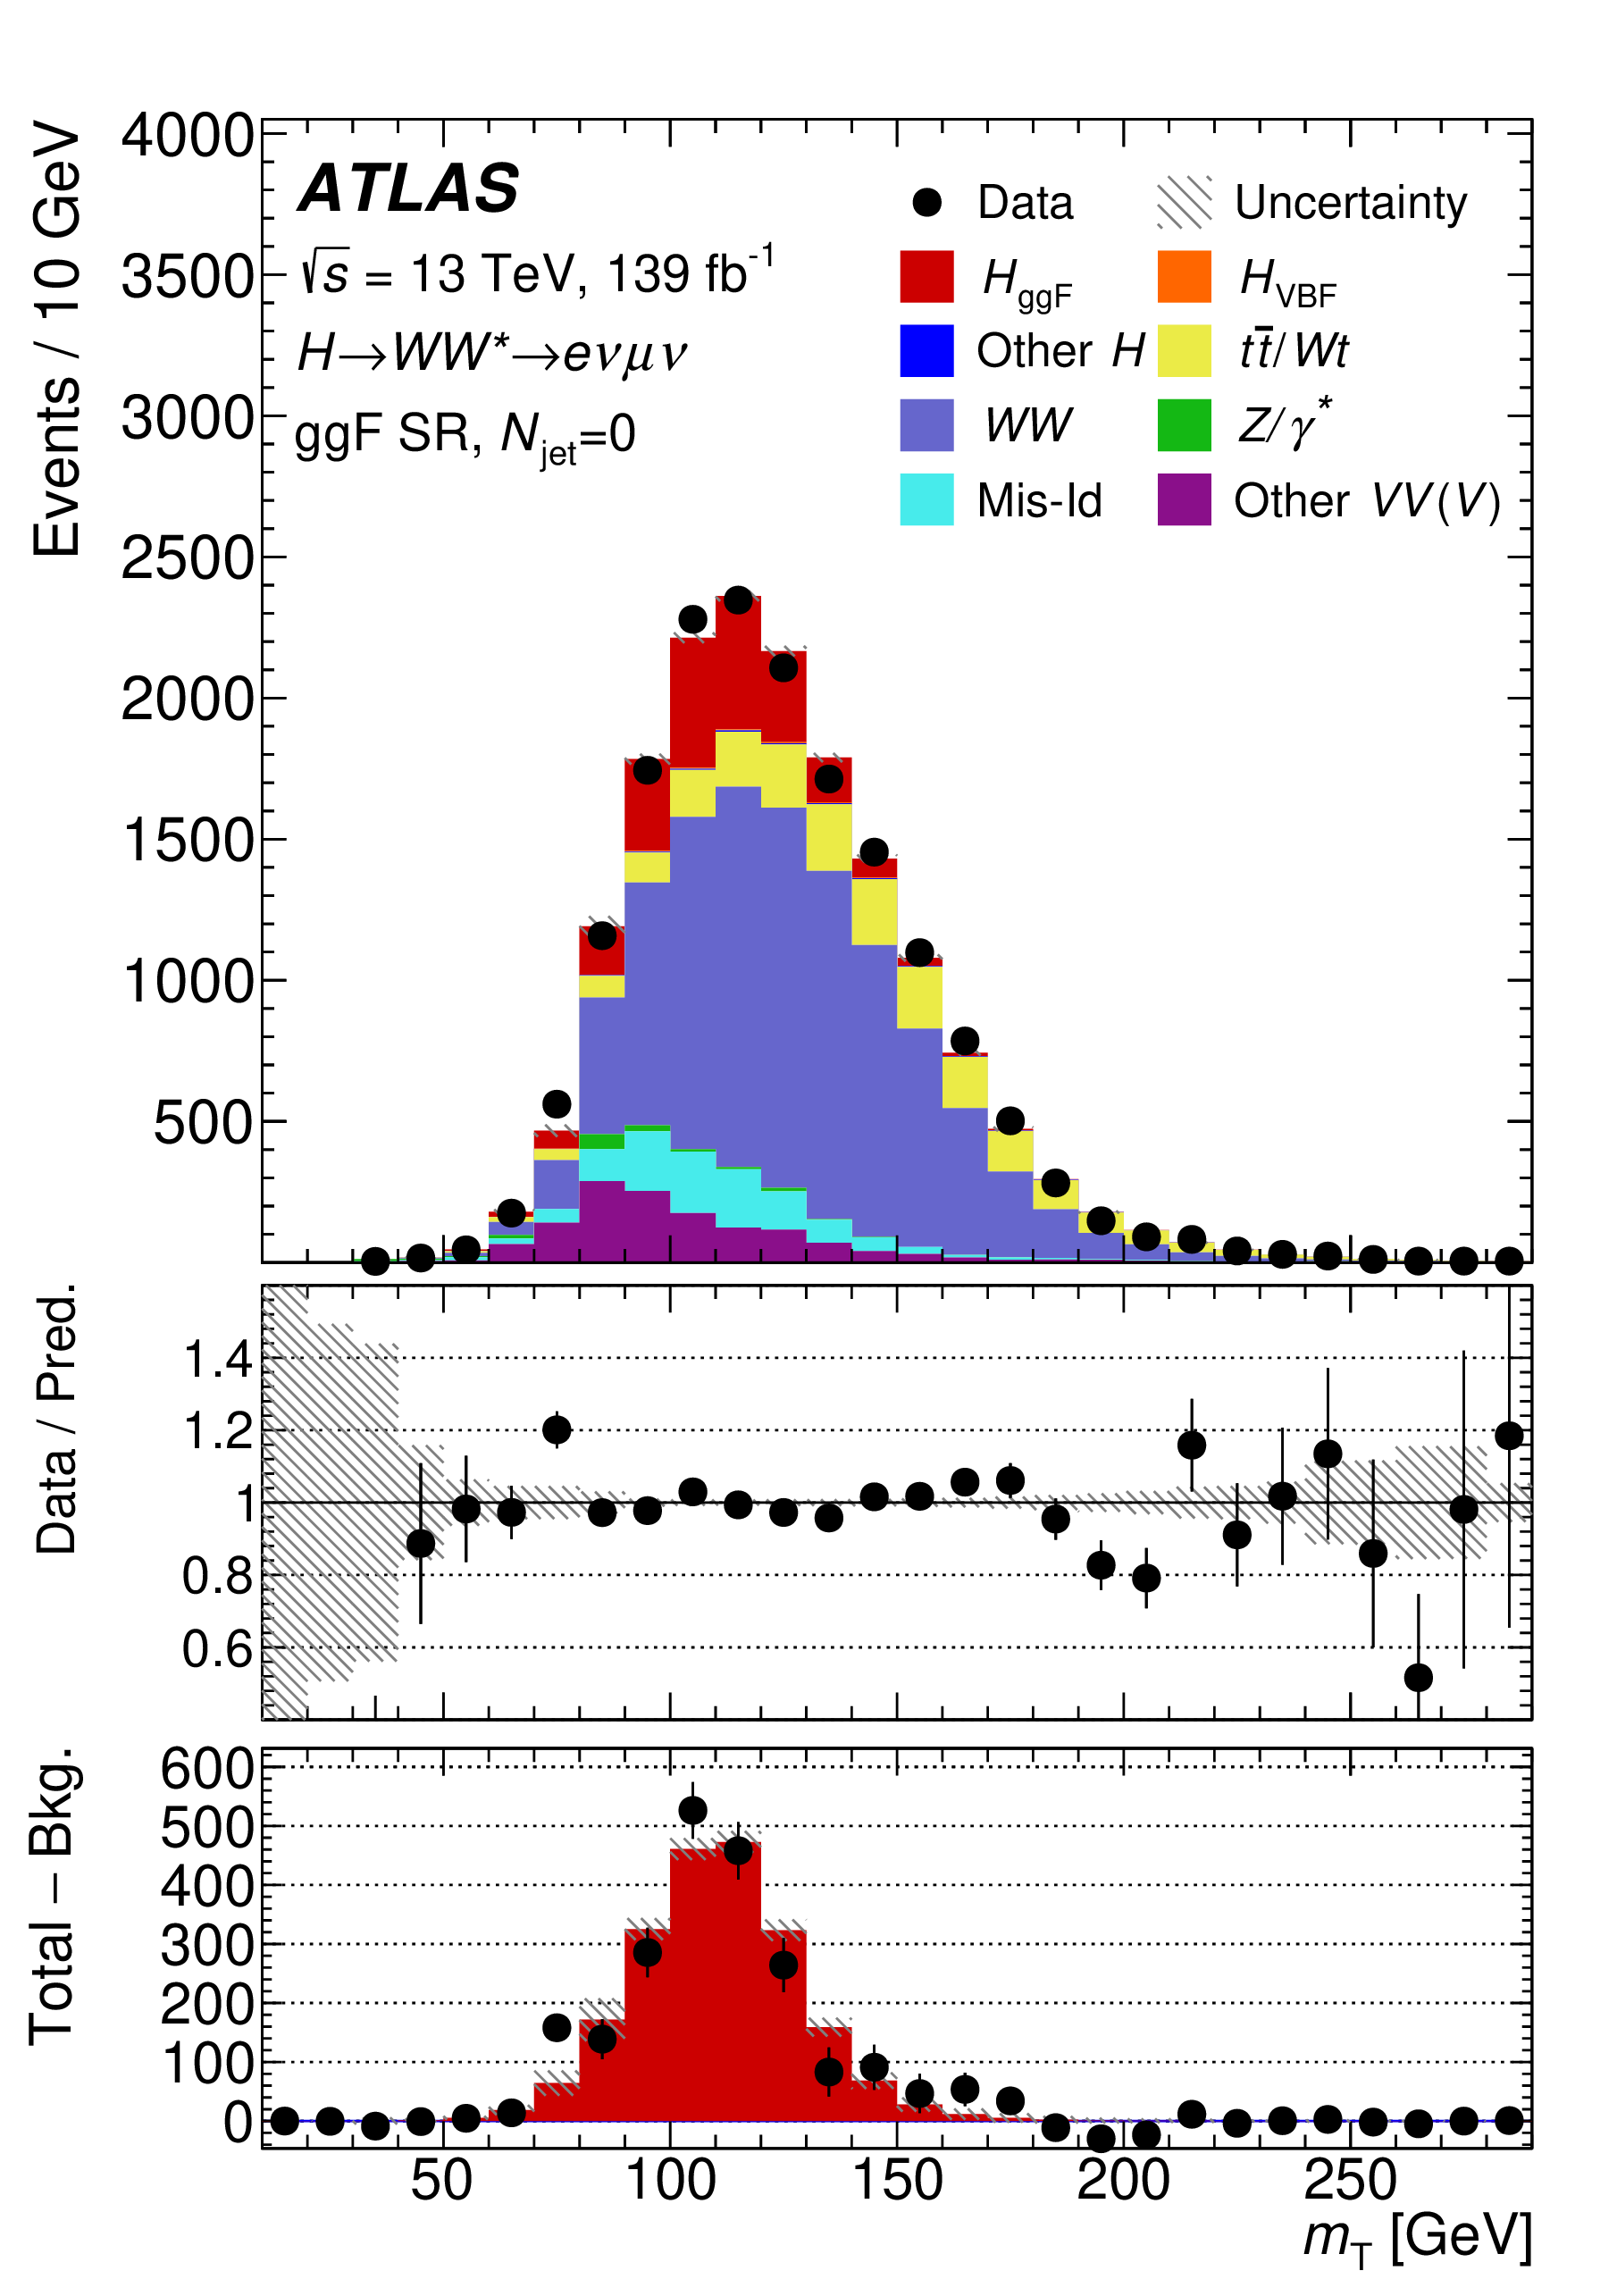</CENTER>

## Intall and import Packages

In [ ]:
import numpy as np  # numpy is a python package for data processing
import pandas as pd  # pandas is a python package for data processing
import matplotlib.pyplot as plt  # matplotlib is a powerful package for plotting results
import uproot  # uproot is a useful python package to read data from root files

import tensorflow as tf
from keras.metrics import AUC

print("Tensorflow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

pd.set_option('display.max_columns', None)  # to see all columns of df.head()

## Load events

Data were created from ATLAS Open Data:

https://opendata.atlas.cern/

The dataset we will be using contains MC simulation of the Standard Model Higgs boson production events (signal), as well as Standard Model background, including top-quark-pair production, single-top production, production of weak bosons in association with jets (W+jets, Z+jets) and production of a pair of bosons (diboson WW, WZ, ZZ).

All the data are stored in a root file, which contains different kinematic variables of each event, the event label (`label`) to indicate whether an event is a signal or background, as well as the MC event weights (`mcWeight`). We use [uproot](https://indico.cern.ch/event/686641/contributions/2894906/attachments/1606247/2548596/pivarski-uproot.pdf) to read data from the root file.

In [ ]:
filename = "dataWW_d1.root"
file = uproot.open(filename)

# show what is inside the root file loaded from uproot
print(file.classnames())

tree = file["tree_event"]  # select the TTree inside the root file
tree.show()  # show all the branches inside the TTree
dfall = tree.arrays(library="pd")  # convert uproot TTree into pandas dataframe
print("============================================")
print("File loaded with ", len(dfall), " events ")

In [ ]:
# dump list of features
dfall.columns

In [ ]:
# examine first few events
dfall.head()

## Event Selection

In this example, we want to focus on events with exactly 2 leptons, so we select events with exactly two leptons using `lep_n`.


In [ ]:
print("Number of events before selections:", len(dfall))
fulldata = dfall[
    ### Complete this line to select only events with exactly two leptons 
    
]  
print("Number of events after selections:", len(fulldata))

The column `label` is whether an event is a signal (Higgs boson events) or a background. An event with the `label == 1` means it is a signal event, otherwise (`label == 0`) it is a background event.

The event weights (`mcWeight`) will be used during the training. Events with a larger weight will have a larger contribution in the loss function.

In [ ]:
target = fulldata.label
weights = fulldata.mcWeight

print("Number of selected signal events:", len(fulldata[target == 1]))
print("Number of selected background events:", len(fulldata[target == 0]))

### For simplicity, we'll only use some features on the first pass

In [ ]:
data = pd.DataFrame(fulldata, columns=["met_et", "met_phi", "lep_pt_0", "lep_pt_1", 'lep_phi_0', 'lep_phi_1'])

# Or we can use more features to improve the discrimination power:
# data=pd.DataFrame(fulldata, columns=["met_et","met_phi","lep_pt_0","lep_pt_1",'lep_eta_0', 'lep_eta_1',
#                                      'lep_phi_0', 'lep_phi_1','jet_n','jet_pt_0',
#                                      'jet_pt_1', 'jet_eta_0', 'jet_eta_1', 'jet_phi_0', 'jet_phi_1'])

# We can also engineer our own feature:
# data["lep_deltaphi"]=np.abs(np.mod(data.lep_phi_1-data.lep_phi_0+3*np.pi,2*np.pi)-np.pi)

data.head()

In [ ]:
plt.figure()
ax = data[target == 0].hist(
    weights=weights[target == 0], figsize=(15, 12), color='b', alpha=0.4, density=True, label="signal"
)
ax = ax.flatten()[: data.shape[1]]  # to avoid error if holes in the grid of plots (like if 7 or 8 features)
data[target == 1].hist(
    weights=weights[target == 1], figsize=(15, 12), color='r', alpha=0.4, density=True, ax=ax, label="background"
)
for i in range(len(ax)):
    ax[i].legend(loc='right')
plt.show()

## Data splitting

It is very common in machine learning to split data into multiple independent sets, and only use part of the data for training/optimizing the machine learning models, and the rest for testing/evaluating performance.

The total dateset is divided into training set, validation set, and test set.

**Training set**: The sample used to train the model. The optimizer runs on this dataset.

**Validation set**: The sample used to provide an unbiased evaluation of a model fit on the training dataset as the model parameters are being updated.

**Test set**: The sample of data used to provide an unbiased evaluation of a final trained model fit on the training dataset.


In the following, we will split the data into 50% training set, 25% validation set and 25% test set.


The API reference of the `train_test_split` function:

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

### Split the Data into training set and rest (validation + test)

In [ ]:
from sklearn.model_selection import train_test_split

(
    X_train,
    X_val_and_test,
    y_train,
    y_val_and_test,
    weights_train,
    weights_val_and_test
) = train_test_split(data, target, weights, train_size=0.5)

print("X_train Shape: ", X_train.shape)
print("y_train Shape: ", y_train.shape)
print("Training Weights shape: ", weights_train.shape, "\n")
print("X_val_and_test Shape: ", X_val_and_test.shape)
print("y_val_and_test Shape: ", y_val_and_test.shape)
print("weights_val_and_test shape: ", weights_val_and_test.shape)

### Split the rest (val + test) into validation set and test set

In [ ]:
(
    X_test,
    X_val,
    y_test,
    y_val,
    weights_test,
    weights_val,
) = ### Complete this line to further split to validation and test set

print("X_train Shape: ", X_train.shape)
print("y_train Shape: ", y_train.shape)
print("weights_train shape: ", weights_train.shape, "\n")
print("X_val Shape: ", X_val.shape)
print("y_val Shape: ", y_val.shape)
print("weights_val shape: ", weights_val.shape, "\n")
print("X_test Shape: ", X_test.shape)
print("y_test Shape: ", y_test.shape)
print("weights_test shape: ", weights_test.shape)

## Standardize the Data

When optimizing the node weights of a neural netowrk, the input scale can significantly affect the performance. That is, unscaled (raw) input variables can result in a slow or unstable learning process. We would therefore like to rescale input variables prior to training a neural network model.

There are 2 common ways to rescale the data:

1. **Scale to Mean of 0 and Variance of 1.0:**   $\ \ \ \ x^\prime = (x-\mu)/\sigma$
2. **Scale to Max of 1 and Min of 0:**   $\ \ \ \ x^\prime = (x-x_{\mathrm{min}})/(x_{\mathrm{max}}-x_{\mathrm{min}})$

In the following, we will go with the first approach, but feel free to try the second approach! (hint: use [sklearn.preprocessing.MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html))

In [ ]:
from sklearn.preprocessing import StandardScaler

print("Before standardization:")
print("X_train mean:", X_train.to_numpy().mean(axis=0).round(2), "std:",  X_train.to_numpy().std(axis=0).round(2))
print("X_val mean:", X_val.to_numpy().mean(axis=0).round(2), "std:",  X_val.to_numpy().std(axis=0).round(2))
print("X_test mean:", X_test.to_numpy().mean(axis=0).round(2), "std:",  X_test.to_numpy().std(axis=0).round(2), "\n")

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print("After standardization:")
print("X_train mean, std: ", X_train.mean(axis=0).round(2), X_train.std(axis=0).round(2))
print("X_val mean, std: ", X_val.mean(axis=0).round(2), X_val.std(axis=0).round(2))
print("X_test mean, std: ", X_test.mean(axis=0).round(2), X_test.std(axis=0).round(2))

## Adjust the Signal/Background Weights for balanced training
Naturally, we would like to have an equal emphasis on the signal and background during the training. To do so, we can "normalize" the signal weights, and background weights such that the sum of weights is the same between signal and background. Note that the adjustment is only needed for train and validation sets, as we do not use test set to calculate the loss function.

In [ ]:
print("Sum of training signal weights before normalization:", weights_train[y_train == 1].sum())
print("Sum of training background weights before normalization:", weights_train[y_train == 0].sum())
print("Sum of validation signal weights before normalization:", weights_val[y_val == 1].sum())
print("Sum of validation background weights before normalization:", weights_val[y_val == 0].sum(), "\n")

weights_train[y_train == 0] *= len(weights_train) / weights_train[y_train == 0].sum()
weights_train[y_train == 1] *= len(weights_train) / weights_train[y_train == 1].sum()

weights_val[y_val == 0] *= len(weights_val) / weights_val[y_val == 0].sum()
weights_val[y_val == 1] *= len(weights_val) / weights_val[y_val == 1].sum()

print("Sum of training signal weights after normalization:", weights_train[y_train == 1].sum())
print("Sum of training background weights after normalization:", weights_train[y_train == 0].sum())
print("Sum of validation signal weights after normalization:", weights_val[y_val == 1].sum())
print("Sum of validation background weights after normalization:", weights_val[y_val == 0].sum())

## Training the neural network

In the following, we will use TensorFlow and Keras to build our neural network and train the model.

### Building the neural network 
**Input layer**: The first layer of a neural network containing its inputs.

**Hidden layers**: Intermediate layers between the input and output layer containing some "hidden" representation of the input data. This representation is built from linear combinations of the features in the preceeding layer followed by application of nonlinearities (activation functions).

**Activation function**: After each hidden layer, an activation function that defines how the weighted sum of the inputs is transformed into the output from a node in this layer of the network. Without these our neural network is entirely linear. A common activation function is `ReLU`, the Rectified Linear Unit function that returns 0 if it receives any negative input, and returns the same values for any positive input.

**Output layer**: The layer that generates the prediction of the network. In the case of a binary classifier, only 1 node is needed for the output layer. In the case of multiclass classification, multiple outputs, one for each class, is needed. The activation function used for the output layer of a binary classifer is the Sigmoid function (gives values between 0 and 1).


_The architecture used in this example is a fully-connected network with 2 hidden layers with the ReLu activation function._
_The last layer uses the Sigmoid activation to output a classifier score that ranges from 0 to 1._

In [ ]:
model = tf.keras.models.Sequential(
    [
        tf.keras.Input((X_train.shape[1],)), # input layer
        tf.keras.layers.Dense(128, activation='relu'),  # layer 1
        ### Complete this line to add another layer with 128 nodes and ReLU activation function, and the last layer with sigmoid activation

    
    ]
)

model.summary()

### Training the neural network 

**Loss function**: mathematical function that quantifies the difference (loss) between predicted values (output) and target values (truth/labels) in some way. We want to minimize this during training. Commonly mean squared error for regression and cross-entropy for classification, but could be anything.

**Optimizer**: Algorithms or method used to change the attributes of the neural network such as weights and learning rate in order to reduce the loss. Model parameters are adjusted in the direction which minimizes the loss function, typically by calculating the derivatives of the loss function with respect to the model parameters. Examples of optimizers include Gradient Descent or the variant Stochastic Gradient Descent, or Adam (Adaptive Moment Estimation algorithm).

_We will use the binary cross-entropy as the loss function, and use the Adam optimizer to train the model._

In [ ]:
model.compile(
    loss="binary_crossentropy",  # use loss="mean_squared_error" for MSE loss
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),  # tf.keras.optimizers.experimental.SGD for the SGD optimizer
    weighted_metrics=[AUC(name="auc")],  # monitor AUC for each epoch during the training
)

### Training and validation loop

**Epochs**: An epoch represents a complete pass through the training set (i.e. the network has seen each event once). Standard neural network trainings will go over many epochs (dozens to hundreds).

**Batches**: During training, the network doesn't see the whole dataset at a time, but rather batches of it (i.e. some fraction). After each batch, the model parameters are updated.

_In the following, we train the model with 10 epochs with a batch size of 128._

In [ ]:
print("Start training!")

# model.fit() performs the training

the_fit = model.fit(
    X_train,
    y_train.values,
    sample_weight=weights_train,
    epochs=10,
    batch_size=128,
    validation_data=(X_val, y_val, weights_val),
    # callbacks=[K.callbacks.EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max')], # uncomment to use early stopping (should also increase the epochs)
)

### Plot the training progress

**ROC curve and AUC**

- **ROC curve (receiver operating characteristic curve)**: a graph showing the performance of a classification model at all classification thresholds. 
- A ROC curve plots **two parameters**: 
    - **True Positive Rate (TPR)** $$ {\rm TPR} = \frac{\rm TP}{{\rm TP}+{\rm FN}}$$
    - **False Positive Rate (FPR)** $${\rm FPR} = \frac{\rm FP}{{\rm FP}+{\rm TN}}$$
- **Classification thresholds**: An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives.

- **AUC**: Area under the ROC Curve. AUC provides an aggregate measure of performance across all possible classification thresholds. One way of interpreting AUC is as the probability that the model ranks a random positive example more highly than a random negative example.

_Below, we plot the training loss, validation loss, training AUC and validation AUC per epoch._

_Ideally, we should see the loss going down, and AUC going up with the number of epochs trained._

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(the_fit.history['loss'], color="tab:blue")
ax.plot(the_fit.history['val_loss'], color="tab:blue", ls="--")
ax.set_xlabel("Epoch", fontsize=14)
ax.set_ylabel("Loss", color='tab:blue', fontsize=14)
ax.tick_params(width=2, grid_alpha=0.5, labelsize=12, axis='y', labelcolor='tab:blue')
ax.tick_params(width=2, grid_alpha=0.5, labelsize=12)
ax.grid(True, axis='y')

ax2 = ax.twinx()
ax2.set_ylabel("ROC AUC", color='tab:orange', fontsize=14)
ax2.tick_params(width=2, grid_alpha=0.5, labelsize=12, axis='y', labelcolor='tab:orange')
ax2.plot(the_fit.history['auc'], color='tab:orange', lw=2)
ax2.plot(the_fit.history['val_auc'], color='tab:orange', ls='--', lw=2)
# ax2.set_ylim([0, 1])

ax2.plot([], [], color="black", label="training set")
ax2.plot([], [], color="black", ls='--', label="validation set")
ax2.legend(fontsize=14, frameon=False, loc="right")
fig.tight_layout()

### Use the model to make predicions!
Evaluate the model based on predictions made with X_test $\rightarrow$ y_test

In [ ]:
y_pred_test = model.predict(X_test).flatten()
y_pred_train = model.predict(X_train).flatten()

print("y_pred_test: ", y_pred_test)
print("y_pred_train: ", y_pred_train)

### ROC curves and Area Under the Curve (AUC)

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr_test, tpr_test, _ = roc_curve(y_true=y_test, y_score=y_pred_test, sample_weight=weights_test)
fpr_train, tpr_train, _ = roc_curve(y_true=y_train, y_score=y_pred_train, sample_weight=weights_train)
plt.plot(fpr_test, tpr_test, color='tab:blue', lw=2, ls="--", label=f"Test set")
plt.plot(fpr_train, tpr_train, color='tab:orange', lw=2, ls=":", label=f"Training set")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Plotting NN Score for Signal and Background

In [ ]:
from math import sqrt
from math import log

def compare_train_test(
    y_pred_train, y_train, y_pred, y_test, high_low=(0,1), 
    bins=30,xlabel="", ylabel="Arbitrary units", title="", 
    weights_train=np.array([]), weights_test=np.array([]),
    density=True):
    
    if weights_train.size != 0:
        weights_train_signal = weights_train[y_train == 1]
        weights_train_background = weights_train[y_train == 0]
    else:
        weights_train_signal = None
        weights_train_background = None
    plt.hist(y_pred_train[y_train == 1],
                 color='r', alpha=0.5, range=high_low, bins=bins,
                 histtype='stepfilled', density=density,
                 label='S (train)', weights=weights_train_signal) # alpha is transparancy
    plt.hist(y_pred_train[y_train == 0],
                 color='b', alpha=0.5, range=high_low, bins=bins,
                 histtype='stepfilled', density=density,
                 label='B (train)', weights=weights_train_background)

    if weights_test.size != 0:
        weights_test_signal = weights_test[y_test == 1]
        weights_test_background = weights_test[y_test == 0]
    else:
        weights_test_signal = None
        weights_test_background = None
    hist, bins = np.histogram(y_pred[y_test == 1],
                                  bins=bins, range=high_low, density=density, weights=weights_test_signal)
    scale = len(y_pred[y_test == 1]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')

    hist, bins = np.histogram(y_pred[y_test == 0],
                                  bins=bins, range=high_low, density=density, weights=weights_test_background)
    scale = len(y_pred[y_test == 0]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='best')

In [ ]:
compare_train_test(
    y_pred_train,
    y_train,
    y_pred_test,
    y_test,
    xlabel="NN Score",
    title="NN",
    weights_train=weights_train.values,
    weights_test=weights_test.values,
)

## Using the classifier score

It is often interesting to understand what the signal sensitivity after applying a selection on the classifier output score. 

Consider the case of the counting experiment above is where the mean background $b$ is known with negligible uncertainty and can be treated as a constant. The median significance can be approximated as 

$Z = \sqrt{2+((s+b)\ln(1+s/b)-s)}$

**see [arXiv:1007.1727](https://arxiv.org/pdf/1007.1727.pdf) [Eq. 97]**

This is a good indication of the performance of our classification model. => We want the significance to be as high as possible.



In [ ]:
from math import sqrt
from math import log


def amsasimov(s, b):
    if b <= 0 or s <= 0:
        return 0
    try:
        return sqrt(2 * ((s + b) * log(1 + float(s) / b) - s))
    except ValueError:
        print(1 + float(s) / b)
        print(2 * ((s + b) * log(1 + float(s) / b) - s))

The simplest way to use the classifier score to separate signal and background is to make a cut on the classifier score for all the events. In the following, we scan through the cut value and look at the corresponding significance. This can help us determine the optimal cut value of the classifier score.

In [ ]:
int_pred_test_sig = [weights_test[(y_test == 1) & (y_pred_test > th_cut)].sum() for th_cut in np.linspace(0, 1, num=50)]
int_pred_test_bkg = [weights_test[(y_test == 0) & (y_pred_test > th_cut)].sum() for th_cut in np.linspace(0, 1, num=50)]
vamsasimov = [amsasimov(sumsig, sumbkg) for (sumsig, sumbkg) in zip(int_pred_test_sig, int_pred_test_bkg)]
Z = max(vamsasimov)

plt.plot(np.linspace(0, 1, num=50), vamsasimov, label=f'Significance ($Z_{{max}} = {np.round(Z, decimals=2)}$)')
plt.title("NN Significance")
plt.xlabel("Cut Value")
plt.ylabel("Significance")
plt.legend()
plt.show()

## What does overtraining look like?

Recipe:
1. Add More layers
2. Add more nodes per layer
3. Train on less data
4. Train for more iterations

In [ ]:
# Crazy Example
N = len(X_train)
n = int(N / 10000)
print("Using", n, "/", N, "events")

X_small = X_train[:n]
y_small = y_train[:n]
weights_small = weights_train[:n]

In [ ]:
ot_model = tf.keras.models.Sequential(
    [
        tf.keras.Input((X_small.shape[1],)),  # input layer
        tf.keras.layers.Dense(512, activation='relu'),  # 1st hiddden layer
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)
ot_model.compile(loss="binary_crossentropy", optimizer="adam", weighted_metrics=[AUC(name="auc")])

the_overfit = ot_model.fit(
    X_small,
    y_small.values,
    sample_weight=weights_small,
    epochs=10,
    batch_size=128,
    validation_data=(X_val, y_val, weights_val),
)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(the_overfit.history['loss'], color="tab:blue")
ax.plot(the_overfit.history['val_loss'], color="tab:blue", ls="--")
ax.set_xlabel("Epoch", fontsize=14)
ax.set_ylabel("Loss", color='tab:blue', fontsize=14)
ax.tick_params(width=2, grid_alpha=0.5, labelsize=12, axis='y', labelcolor='tab:blue')
ax.tick_params(width=2, grid_alpha=0.5, labelsize=12)
ax.grid(True, axis='y')

ax2 = ax.twinx()
ax2.set_ylabel("ROC AUC", color='tab:orange', fontsize=14)
ax2.tick_params(width=2, grid_alpha=0.5, labelsize=12, axis='y', labelcolor='tab:orange')
ax2.plot(the_overfit.history['auc'], color='tab:orange', lw=2)
ax2.plot(the_overfit.history['val_auc'], color='tab:orange', ls='--', lw=2)
# ax2.set_ylim([0, 1])

ax2.plot([], [], color="black", label="training set")
ax2.plot([], [], color="black", ls='--', label="validation set")
ax2.legend(fontsize=14, frameon=False, loc="right")
fig.tight_layout()

## Exercises

### Can we try to improve the neural network performance?

Hints:
- Adjust learning rate
- Adjust the number of neurons, and layers
- Increase epochs
- Enable early stopping (and increase max epochs)
- Adjust batch size
- Change activations: [relu, leakyrelu, selu, tanh]
- Try different optimizers (e.g. SGD)
- Dynamic learning rate: e.g. tfa.optimizers.RectifiedAdam as the optimizer, tf.keras.callbacks.ReduceLROnPlateau as a callback
- Use a more complicated structure? e.g. RNN, deep sets, GNN, etc
- More... google!

### What happens when we add more features or engineer aditional Features?

Try it yourself!

### What happens when we don't standardize our inputs?

Try it yourself!

What about a different prescaling (using [sklearn.preprocessing.MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for example?)

### What happens when we don't use balanced weights for signal and background?

Use the raw MC weights and retrain the model.

Does the "natural" weight always give the best performance?